# Requirements

In [1]:
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.stats import pearsonr

import nltk

import sddk
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import geoplot as gplt

In [2]:
# setup sciencedata, google and figures exports
# (feel free to skip...)

s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".eps", format="eps")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [317]:
# establish connection with gogglesheets...
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict") # or load it from a local storage: json.load(open("../../ServiceAccountsKey.json", "r"))
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import datasets

In [4]:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")

In [5]:
LIRE[LIRE["is_western"]]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
210,EDCS-21300235,"CIL 06, 00882 (p 3777, 4302, 4367) = CIL 06, 3...",Aegyptus,Aegyptus,Al Iskandariyah / Alexandria,"['Al Iskandariyah', 'Alexandria']",20,,"['Augusti/Augustae', 'tituli sacri', 'viri']",tituli sacri,...,9998.65,1002,"[12.395451, 42.021684]",15756.86,large,[faber],1,[],0,"[Production and related workers, transport equ..."
281,EDCS-12800362,"AE 1964, 00222",Aemilia / Regio VIII,Aemilia / Regio VIII,Bagno di Romagna,Bagno di Romagna,200,,"['tituli sacri', 'viri']",tituli sacri,...,41767.45,937,"[11.903398, 43.983123]",17068.12,rural,[],0,[],0,[]
282,EDCS-09300206,"AE 1976, 00204",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
283,EDCS-09300210,"AE 1976, 00208",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['liberti/libertae', 'mulieres', 'tituli sepul...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
284,EDCS-09300215,"AE 1976, 00213",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",100,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136185,EDCS-10700071,"SupIt-12-IC, 00047 = IulCarnicum-02, 00125",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136186,EDCS-10700072,"SupIt-12-IC, 00048 = IulCarnicum-02, 00137",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136187,EDCS-10700073,"SupIt-12-IC, 00049 = IulCarnicum-02, 00134",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136188,EDCS-10700074,"SupIt-12-IC, 00050 = IulCarnicum-02, 00115",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",25,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]


In [6]:
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[]
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,60414.04,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[]
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{ },{ },...,45272.69,35,"[21.435443, 37.827452]",26125.55,large,[],0,[],0,[]


In [22]:
# mask
before235 = LIRE["not_before"] < 235
after235 = LIRE["not_before"]>=235

In [23]:
len(LIRE[before235])

114898

In [24]:
LIRE[before235]["occups_N"].sum()

4751

In [25]:
LIRE[before235]["occups_N"].sum() / LIRE["occups_N"].sum()

0.9168274797375531

In [42]:
roman_cities = gpd.read_parquet("../data/roman_cities_pop.parquet")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [45]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
LIRE["city_ID"] = LIRE.apply(lambda row: get_my_city(row), axis=1)

In [46]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIRE[LIRE["city_ID"]==str(ID)]
    city_data_post235 = LIRE[(LIRE["city_ID"]==str(ID)) & (after235)]
    if len(city_data) > 0:
        # all inscriptions
        city_dict["inscr_N"] = len(city_data)
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_unique_N"] = len(set(city_dict["occups_list"]))
    # inscriptions pre 235
        city_dict["inscr_N_post235"] = len(city_data_post235)
        city_dict["occups_N_post235"] = city_data_post235["occups_N"].sum()
        city_dict["ratio_post235"] = len(city_data_post235) / len(city_data)
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [47]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,[],0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

In [49]:
del cities_inscr_data
del cities_dict_data

# Explore inscriptions within cities

In [50]:
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,pop_est,pop_diff,western_province,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,1700.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,1000.0,NaN,False,1.0,[],0.0,0.0,0.0,0.0,0.0
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,8209.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# all cities
len(roman_cities)

1388

In [52]:
roman_cities["pop_est"].sum()

10214337.0

In [53]:
roman_cities["inscr_N"].sum()

109369.0

In [54]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

856

In [55]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

0.6167146974063401

In [56]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [57]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

657

In [58]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.7390326209223848

In [66]:
LIRE["is_western"].sum()

125640

In [67]:
LIRE["is_western"].sum() / len(LIRE)

0.9225346941772524

# Focus on western cities alone - basic explorations (feel free to skip)

In [69]:
roman_cities = roman_cities[roman_cities["western_province"]]
len(roman_cities)

889

In [70]:
roman_cities["pop_est"].sum()

5368578.0

In [74]:
len(LIRE[(LIRE["urban_context_alt"]=="rural") & (LIRE["is_western"])])

23122

In [71]:
roman_cities["inscr_N"].sum()

102489.0

In [76]:
102489.0 + 23122

125611.0

In [101]:
roman_cities["pop_est_log"] = np.log(roman_cities["pop_est"])
roman_cities["inscr_N_log"] = np.log(roman_cities["inscr_N"])
roman_cities["occups_N_log"] = np.log(roman_cities["occups_N"])

/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Measuring Specialization and Diversity

In [102]:
len(roman_cities)

889

In [103]:
(roman_cities["occups_N"]>0).sum()

313

In [104]:
roman_cities[roman_cities["occups_N"]>0]["inscr_N"].sum()

97216.0

In [105]:
roman_cities[roman_cities["occups_N"]>0]["pop_est"].sum()

3242265.0

In [106]:
3242265.0 / 5368578.0

0.6039336673510192

In [237]:
3242265.0 / 10214337.0

0.3174229516805643

In [107]:
97216 / len(LIRE)

0.7138262721198326

In [108]:
# roman cities western with at least one occupations
roman_cities_wo = roman_cities[roman_cities["occups_N"]>0].copy()

In [242]:
roman_cities_wo["occups_N"].sum()

4412.0

In [241]:
roman_cities_wo["occups_N"].sum() / 5182

0.8514087225009649

In [109]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235,pop_est_log,inscr_N_log,occups_N_log
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.0,[curator],1.0,1.0,1.0,1.0,1.000000,6.907755,0.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,45.0,"[scaenicus, curator, tonsor, possessor, faber]",5.0,5.0,8.0,1.0,0.177778,8.905987,3.806662,1.609438
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,474.0,"[curator, mesor, curator, mensor, agrimensor, ...",9.0,6.0,39.0,0.0,0.082278,11.533453,6.161207,2.197225
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,2.0,[sartor],1.0,1.0,2.0,1.0,1.000000,6.907755,0.693147,0.000000
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,13.0,"[faber, faber]",2.0,1.0,4.0,0.0,0.307692,10.480803,2.564949,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,120.0,[faber],1.0,1.0,13.0,0.0,0.108333,10.247432,4.787492,0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,6.0,[faber],1.0,1.0,1.0,0.0,0.166667,9.351579,1.791759,0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,29.0,"[curator, curator]",2.0,1.0,6.0,0.0,0.206897,8.521584,3.367296,0.693147
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,28.0,[forensis],1.0,1.0,0.0,0.0,0.000000,8.405367,3.332205,0.000000


In [110]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [111]:
print(len(set(occups_cats_dict.values())))
set(occups_cats_dict.values())

19


{'Building',
 'Clothing',
 'Death-care sector',
 'Education',
 'Finance',
 'Food-Production',
 'Food-Retail',
 'Fuel / Raw material',
 'Glass-Working',
 'Household Goods',
 'Managerial',
 'Metal-Working',
 'Miscellaneous Services',
 'Performing Arts',
 'Plastic Arts',
 'Retail',
 'Transport',
 'Unclear meaning',
 'Water-Management'}

In [112]:
occups_cats_labels = list(set(occups_cats_dict.values()))
occups_cats_labels

['Unclear meaning',
 'Metal-Working',
 'Food-Retail',
 'Transport',
 'Education',
 'Finance',
 'Retail',
 'Building',
 'Miscellaneous Services',
 'Plastic Arts',
 'Managerial',
 'Household Goods',
 'Clothing',
 'Performing Arts',
 'Water-Management',
 'Glass-Working',
 'Death-care sector',
 'Fuel / Raw material',
 'Food-Production']

In [113]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
roman_cities_wo["occups_cats_list"] = roman_cities_wo["occups_list"].apply(cat_for_occup)

In [114]:
roman_cities_wo["occups_cats_unique_N"] = roman_cities_wo["occups_cats_list"].apply(lambda x: len(set(x)))
roman_cities_wo["occups_cats_unique_N"]

159     1
165     4
171     3
174     1
177     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 313, dtype: int64

In [115]:
len(roman_cities_wo[roman_cities_wo["occups_N"]==1])

85

In [116]:
85 / 313

0.2715654952076677

Text(0, 0.5, 'N cities')

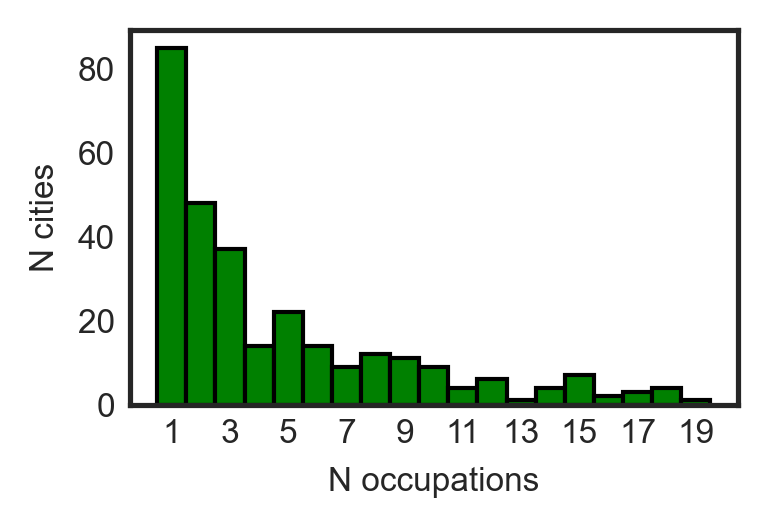

In [117]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_N"].hist(ax=ax, edgecolor="black", color="green", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("N occupations")
ax.set_ylabel("N cities")

Text(0, 0.5, 'N cities')

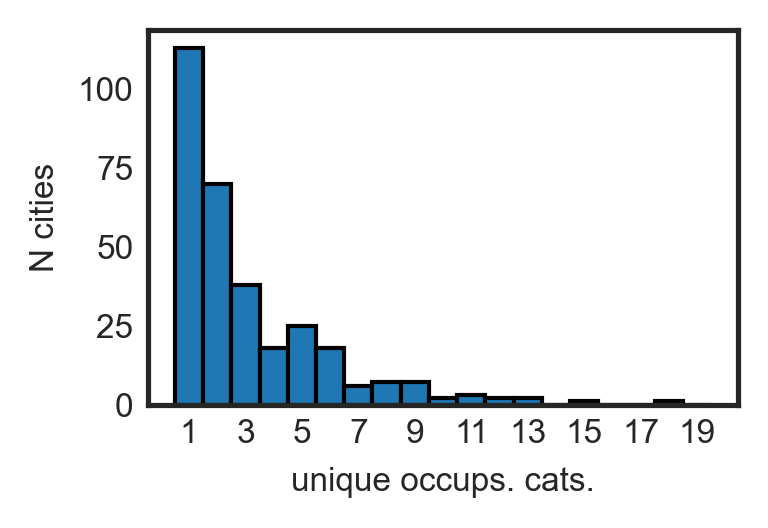

In [118]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_cats_unique_N"].hist(ax=ax, edgecolor="black", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("unique occups. cats.")
ax.set_ylabel("N cities")

In [39]:
save_figure(fig, "unique_cats_per_cities_hist")

A file with the same name ("unique_cats_per_cities_hist.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.eps"
A file with the same name ("unique_cats_per_cities_hist.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.png"


In [119]:
roman_cities_wo["occups_cats_list"]

159                                          [Managerial]
165     [Performing Arts, Managerial, Miscellaneous Se...
171     [Managerial, Miscellaneous Services, Manageria...
174                              [Miscellaneous Services]
177                        [Metal-Working, Metal-Working]
                              ...                        
1297                                      [Metal-Working]
1311                                      [Metal-Working]
1315                             [Managerial, Managerial]
1317                                         [Managerial]
1321                             [Managerial, Managerial]
Name: occups_cats_list, Length: 313, dtype: object

# Specialization

In [120]:
def get_cat_row_vec(cat_list):
    cat_row_vec = []
    for cat in occups_cats_labels:
        cat_row_vec.append(cat_list.count(cat))
    return np.array(cat_row_vec)


In [121]:
roman_cities_wo["occups_cats_vec"] = roman_cities_wo["occups_cats_list"].apply(get_cat_row_vec)
roman_cities_wo["occups_cats_vec"]

159     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
165     [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, ...
171     [0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, ...
174     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
177     [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
1297    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1311    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1315    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...
1317    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
1321    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...
Name: occups_cats_vec, Length: 313, dtype: object

In [122]:
def occups_cats_vec_weighted(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = a / sum(a)
    return a
roman_cities_wo["shares_vec"] = roman_cities_wo["occups_cats_vec"].apply(occups_cats_vec_weighted)
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, ...
171     [0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
177     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [123]:
roman_cities_wo["ZI"] = roman_cities_wo["shares_vec"].apply(max)
roman_cities_wo["ZI"]

159     1.000000
165     0.400000
171     0.666667
174     1.000000
177     1.000000
          ...   
1297    1.000000
1311    1.000000
1315    1.000000
1317    1.000000
1321    1.000000
Name: ZI, Length: 313, dtype: float64

In [124]:
roman_cities_wo["largest_cat"] = roman_cities_wo["occups_cats_vec"].apply(max)

In [125]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ratio_post235,pop_est_log,inscr_N_log,occups_N_log,occups_cats_list,occups_cats_unique_N,occups_cats_vec,shares_vec,ZI,largest_cat
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.000000,6.907755,0.000000,0.000000,[Managerial],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,0.177778,8.905987,3.806662,1.609438,"[Performing Arts, Managerial, Miscellaneous Se...",4,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, ...","[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, ...",0.400000,2
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,0.082278,11.533453,6.161207,2.197225,"[Managerial, Miscellaneous Services, Manageria...",3,"[0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, ...","[0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, ...",0.666667,6
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.000000,6.907755,0.693147,0.000000,[Miscellaneous Services],1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1.000000,1
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,0.307692,10.480803,2.564949,0.693147,"[Metal-Working, Metal-Working]",1,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,0.108333,10.247432,4.787492,0.000000,[Metal-Working],1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,0.166667,9.351579,1.791759,0.000000,[Metal-Working],1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,0.206897,8.521584,3.367296,0.693147,"[Managerial, Managerial]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,2
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,0.000000,8.405367,3.332205,0.000000,[Managerial],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1


In [126]:
roman_cities_wo["ZI_cat"] = roman_cities_wo["shares_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])

In [127]:
roman_cities_wo.sort_values("ZI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N","occups_cats_vec", "ZI", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZI_cat
159,Acholla,1.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1.000000,Managerial
605,Cabillonum,27.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.000000,Miscellaneous Services
855,Grumentum,16.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...",1.000000,Managerial
862,Potentia (Italia (III Lucania et Brutii)),17.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1.000000,Managerial
871,Aequi,26.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1.000000,Managerial
...,...,...,...,...,...,...,...
789,Pompeii,3297.0,56.0,11,"[0, 7, 0, 1, 0, 2, 7, 3, 10, 2, 9, 0, 3, 9, 0,...",0.178571,Miscellaneous Services
1268,Brigetio,438.0,17.0,9,"[0, 2, 0, 1, 0, 1, 2, 0, 3, 1, 3, 0, 3, 0, 0, ...",0.176471,Miscellaneous Services
785,Norba,106.0,12.0,8,"[0, 0, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, ...",0.166667,Retail
1271,Mursa,109.0,6.0,6,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, ...",0.166667,Retail


In [128]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list","occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,ZI_cat
1287,Augusta Vindelicum,210.0,10.0,"[negotiator, negotiator, vestiarius, negotiato...",2,"[0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.900000,2.072327,Retail
873,Alba Fucentia,82.0,12.0,"[curator, curator, curator, tignuarius, curato...",3,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 10, 0, 0, 0, 0,...",0.833333,2.070756,Managerial
991,Roma,39882.0,1855.0,"[faber, curator, curator, aerarius, scriba, cu...",18,"[3, 274, 24, 22, 110, 30, 112, 120, 311, 32, 4...",0.266846,2.008190,Managerial
1058,Patavium,175.0,17.0,"[aerarius, aerarius, curator, faber, aerarius,...",3,"[0, 12, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,...",0.705882,1.999915,Metal-Working
332,Carmo,28.0,11.0,"[scaenicus, diffusor, olearius, agrimensor, ag...",4,"[0, 0, 1, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 1, 0, ...",0.727273,1.743924,Miscellaneous Services
...,...,...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,[dendrophorus],1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Building
605,Cabillonum,27.0,1.0,[unguentarius],1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Miscellaneous Services
596,Agedincum,3.0,1.0,[aerarius],1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Metal-Working
583,Beda,46.0,1.0,[medicus],1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Miscellaneous Services


In [129]:
# Total shares
all_occups_N = roman_cities_wo["occups_N"].sum()
index_label_sum_dict = {}
for i, cat in zip(range(len(occups_cats_labels)), occups_cats_labels):
    cat_sum = sum(roman_cities_wo["occups_cats_vec"].apply(lambda vec: vec[i]))
    cat_share = cat_sum / all_occups_N
    index_label_sum_dict[i] = [cat, cat_sum, cat_share]
index_label_sum_dict

{0: ['Unclear meaning', 4, 0.0009066183136899365],
 1: ['Metal-Working', 936, 0.21214868540344514],
 2: ['Food-Retail', 51, 0.011559383499546692],
 3: ['Transport', 132, 0.029918404351767906],
 4: ['Education', 215, 0.04873073436083409],
 5: ['Finance', 68, 0.015412511332728921],
 6: ['Retail', 301, 0.06822302810516773],
 7: ['Building', 285, 0.06459655485040798],
 8: ['Miscellaneous Services', 592, 0.13417951042611062],
 9: ['Plastic Arts', 53, 0.01201269265639166],
 10: ['Managerial', 1052, 0.2384406165004533],
 11: ['Household Goods', 36, 0.008159564823209429],
 12: ['Clothing', 290, 0.0657298277425204],
 13: ['Performing Arts', 163, 0.03694469628286491],
 14: ['Water-Management', 14, 0.003173164097914778],
 15: ['Glass-Working', 8, 0.001813236627379873],
 16: ['Death-care sector', 0, 0.0],
 17: ['Fuel / Raw material', 1, 0.00022665457842248413],
 18: ['Food-Production', 211, 0.04782411604714415]}

In [130]:
total_shares = np.array([val[2] for val in index_label_sum_dict.values()])
total_shares

array([9.06618314e-04, 2.12148685e-01, 1.15593835e-02, 2.99184044e-02,
       4.87307344e-02, 1.54125113e-02, 6.82230281e-02, 6.45965549e-02,
       1.34179510e-01, 1.20126927e-02, 2.38440617e-01, 8.15956482e-03,
       6.57298277e-02, 3.69446963e-02, 3.17316410e-03, 1.81323663e-03,
       0.00000000e+00, 2.26654578e-04, 4.78241160e-02])

In [131]:
def get_shares_weighted(vec):
    a = np.array(vec, dtype=float)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return shares_weighted

roman_cities_wo["shares_weighted_vec"] = roman_cities_wo["shares_vec"].apply(lambda vec: get_shares_weighted(vec))
roman_cities_wo["shares_weighted_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.9427350427350428, 0.0, 0.0, 0.0, 0.0, ...
171     [0.0, 0.523741690408357, 0.0, 0.0, 0.0, 0.0, 0...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.452...
177     [0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...
                              ...                        
1297    [0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...
1311    [0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_weighted_vec, Length: 313, dtype: object

In [132]:
roman_cities_wo["RZI"] = roman_cities_wo["shares_weighted_vec"].apply(max)
roman_cities_wo["RZI"]

159     4.193916
165     5.413497
171     4.968468
174     7.452703
177     4.713675
          ...   
1297    4.713675
1311    4.713675
1315    4.193916
1317    4.193916
1321    4.193916
Name: RZI, Length: 313, dtype: float64

In [133]:
roman_cities_wo["RZI_cat"] = roman_cities_wo["shares_weighted_vec"].apply(lambda x: index_label_sum_dict[np.argmax(x)][0])
roman_cities_wo["RZI_cat"]

159                 Managerial
165            Performing Arts
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: RZI_cat, Length: 313, dtype: object

In [134]:
roman_cities_wo["RZIw"] = roman_cities_wo.apply(lambda row: row["RZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("RZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "RZI_cat", "RZI", "RZIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,RZI_cat,RZI,RZIw
659,Colonia Agrippinensis,1255.0,37.0,12,"[1, 3, 1, 0, 1, 2, 13, 3, 6, 0, 2, 0, 1, 1, 0,...",0.351351,1.268701,Unclear meaning,29.810811,107.644391
1276,Carnuntum (1),1155.0,18.0,10,"[0, 4, 0, 0, 1, 0, 1, 1, 4, 1, 2, 0, 2, 0, 0, ...",0.222222,0.642305,Glass-Working,30.638889,88.557779
1277,Carnuntum (2),353.0,8.0,7,"[0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, ...",0.250000,0.519860,Water-Management,39.392857,81.915144
663,Andematunum,310.0,12.0,7,"[0, 1, 3, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 2, 0, ...",0.250000,0.621227,Food-Retail,21.627451,53.742197
666,Argentoratum,214.0,5.0,3,"[0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, ...",0.400000,0.643775,Plastic Arts,33.298113,53.591246
...,...,...,...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Building,15.480702,0.000000
605,Cabillonum,27.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Miscellaneous Services,7.452703,0.000000
596,Agedincum,3.0,1.0,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Metal-Working,4.713675,0.000000
583,Beda,46.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Miscellaneous Services,7.452703,0.000000


# Diversity

In [135]:
# again, the starting point are the shares:
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, ...
171     [0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
177     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [136]:
def get_di(shares_vec):
    a = np.array(shares_vec)
    a = a**2
    hh = sum(a) # Hirschman-Herfindahl index
    ihh = 1 / hh # inverse Hirschman-Herfindahl index
    return ihh
roman_cities_wo["DI"] = roman_cities_wo["shares_vec"].apply(get_di)

In [137]:
roman_cities_wo.sort_values("DI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "DI"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,DI
789,Pompeii,3297.0,56.0,11,"[0, 7, 0, 1, 0, 2, 7, 3, 10, 2, 9, 0, 3, 9, 0,...",7.919192
1268,Brigetio,438.0,17.0,9,"[0, 2, 0, 1, 0, 1, 2, 0, 3, 1, 3, 0, 3, 0, 0, ...",7.410256
785,Norba,106.0,12.0,8,"[0, 0, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, ...",7.200000
672,Mogontiacum,3065.0,59.0,12,"[0, 7, 0, 3, 1, 4, 15, 2, 8, 0, 10, 1, 3, 2, 0...",7.089613
1276,Carnuntum (1),1155.0,18.0,10,"[0, 4, 0, 0, 1, 0, 1, 1, 4, 1, 2, 0, 2, 0, 0, ...",7.043478
...,...,...,...,...,...,...
769,Ferentinum,112.0,4.0,1,"[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
772,Frusino,28.0,5.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...",1.000000
818,Ausculum,12.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1.000000
833,Lupiae,38.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000


In [140]:
def get_diw(a,b):
    if b==0:
        return 0
    else:
        return a / b
roman_cities_wo["DIw"] = roman_cities_wo.apply(lambda row: get_diw(row["DI"], row['occups_N_log']), axis=1)
roman_cities_wo.sort_values("DIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list", "occups_cats_unique_N", "DI", "DIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,DI,DIw
1271,Mursa,109.0,6.0,"[conditor, vexillarius, scriptor, negotiator, ...",6,6.0,3.348664
1045,Ateste,128.0,6.0,"[navalis, aerarius, curator, medicus, pectinat...",6,6.0,3.348664
1283,Siscia,116.0,5.0,"[ferrarius, scriba, centonarius, medicus, dend...",5,5.0,3.106675
662,Noviomagus (Germania Inferior),103.0,5.0,"[scriba, negotiator, tignarius, faber, sutor]",5,5.0,3.106675
1277,Carnuntum (2),353.0,8.0,"[faber, faber, curator, centonarius, lecticari...",7,6.4,3.077749
...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,[dendrophorus],1,1.0,0.000000
605,Cabillonum,27.0,1.0,[unguentarius],1,1.0,0.000000
596,Agedincum,3.0,1.0,[aerarius],1,1.0,0.000000
583,Beda,46.0,1.0,[medicus],1,1.0,0.000000


# Overview tables

In [254]:
all_measures = [["ZIw", "ZI_cat"], ["RZIw", "RZI_cat"], ["DI"], ["DIw"]]
sel_cols = ["Ancient Toponym", "pop_est", "inscr_N", "occups_N", "largest_cat", "occups_cats_unique_N"]

In [255]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.000000,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,0.000000,1.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,0.400000,2,Managerial,0.643775,"[0.0, 0.9427350427350428, 0.0, 0.0, 0.0, 0.0, ...",5.413497,Performing Arts,8.712687,3.571429,2.219053
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,0.666667,6,Miscellaneous Services,1.464816,"[0.0, 0.523741690408357, 0.0, 0.0, 0.0, 0.0, 0...",4.968468,Miscellaneous Services,10.916841,1.975610,0.899139
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.000000,1,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.452...",7.452703,Miscellaneous Services,0.000000,1.000000,0.000000
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,1.000000,2,Metal-Working,0.693147,"[0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...",4.713675,Metal-Working,3.267271,1.000000,1.442695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,1.000000,1,Metal-Working,0.000000,"[0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...",4.713675,Metal-Working,0.000000,1.000000,0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,1.000000,1,Metal-Working,0.000000,"[0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...",4.713675,Metal-Working,0.000000,1.000000,0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,1.000000,2,Managerial,0.693147,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,2.907001,1.000000,1.442695
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1.000000,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,0.000000,1.000000,0.000000


In [260]:
cols_renaming = {"Ancient Toponym" : "city",
                 "pop_est" : "pop. est.",
                 "inscr_N" : "N inscriptions",
                 "occups_N" : "N occupations",
                 "occups_cats_unique_N": "N sectors",
                 "ZI_cat" : "largest sector",
                 "RZI_cat" : "largest sector",
                 "largest_cat" : "N occ. in largest sector"
                 }

In [261]:
def get_sorted_table(df, sel_cols, measures):
    df = df[sel_cols + measures]
    df_sorted = df.sort_values(measures[0], ascending=False)
    for col in ["inscr_N", "pop_est", "occups_N", "occups_cats_unique_N"]:
        df_sorted[col] = df_sorted[col].astype(int)
    for val_col in ["ZIw", "RZIw", "DI", "DIw"]:
        try:
            df_sorted[val_col] = df_sorted[val_col].round(2)
        except:
            pass
    df_sorted = df_sorted.rename(columns=cols_renaming)
    return df_sorted.head(10) # .append(df_sorted.tail(3))

In [262]:
sorted_dfs = {}
for measure_cols in all_measures:
    sorted_dfs["sorted_by_" + measure_cols[0]] = get_sorted_table(roman_cities_wo, sel_cols, measure_cols)

In [263]:
sorted_dfs["sorted_by_ZIw"]

,city,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,ZIw,largest sector
1287,Augusta Vindelicum,10608,210,10,9,2,2.07,Retail
873,Alba Fucentia,4471,82,12,10,3,2.07,Managerial
991,Roma,923313,39882,1855,495,18,2.01,Managerial
1058,Patavium,27923,175,17,12,3,2.00,Metal-Working
332,Carmo,7172,28,11,8,4,1.74,Miscellaneous Services
781,Minturnae,4471,106,9,7,3,1.71,Managerial
746,Aquinum,12445,392,37,17,8,1.66,Managerial
820,Beneventum,7172,242,35,16,8,1.63,Managerial
772,Frusino,1000,28,5,5,1,1.61,Managerial
402,Petuaria,1000,7,5,5,1,1.61,Metal-Working


In [264]:
# export to gsheets
set_with_dataframe(socdiv_results.add_worksheet("sorted_by_ZIw_10", 1,1), sorted_dfs["sorted_by_ZIw"])

In [265]:
# save to csv
sorted_dfs["sorted_by_ZIw"].to_csv("../data/sorted_by_ZIw_10.csv", index=None)

In [ ]:
### latex version...

In [266]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Augusta Vindelicum"][]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
1287,Hanson2016_1288,Augusta Vindelicum,Augsburg,Raetia,Germany,2,12 D4,-15,NaN,BNP; Boatwright 2000; McEvedy 2011; PECS; Quin...,...,0.9,9,Retail,2.072327,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.192026578073...",13.192027,Retail,30.375764,1.219512,0.529627


In [271]:
LIRE[(LIRE["city_ID"]=="1288") & (LIRE["occups_N"]>0)]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats,city_ID
45003,EDCS-27100317,"CIL 03, 05800 (p 1853) = D 07108 = IBR 00111",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['officium/professio', 'ordo decurionum', 'ord...",tituli operum,...,1287,"[10.909768, 47.909884]",50673.56,medium,[negotiator],1,[],0,[Sales workers],1288
45019,EDCS-27100333,"CIL 03, 05816 = IBR 00127",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['milites', 'officium/professio', 'tituli sepu...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",51368.73,medium,"[negotiator, vestiarius]",2,[],0,"[Sales workers, Sales workers]",1288
45027,EDCS-27200188,"CIL 03, 05824 = D 07598 = IBR 00135",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['mulieres', 'officium/professio', 'seviri Aug...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",50255.03,medium,[negotiator],1,[],0,[Sales workers],1288
45033,EDCS-27200194,"CIL 03, 05830 = IBR 00141 (p V) = CSIR-D-01-01...",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['officium/professio', 'tituli sepulcrales', '...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",50989.15,medium,[negotiator],1,[],0,[Sales workers],1288
45036,EDCS-27200197,"CIL 03, 05833 = IBR 00144",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['mulieres', 'officium/professio', 'tituli sep...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",50255.03,medium,"[negotiator, cretaria]",2,[],0,"[Sales workers, Sales workers]",1288
45070,EDCS-37600014,"IBR 00175,1 (p V)",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",51229.86,medium,[lanius],1,[],0,"[Production and related workers, transport equ...",1288
45089,EDCS-31001577,"Wagner-02, 00025",Raetia,Raetia,Augsburg / Augusta Vindelicorum,"['Augsburg', 'Augusta Vindelicorum']",300,,"['officium/professio', 'tituli operum', 'titul...","['tituli operum', 'tituli sacri']",...,1287,"[10.909768, 47.909884]",51417.45,medium,[negotiator],1,[],0,[Sales workers],1288
45470,EDCS-73200092,"AJahrBay-2014-70 = AE 2015, 01031",Raetia,Raetia,Oberhausen / Augsburg-Oberhausen / Augusta Vin...,"['Oberhausen', 'Augsburg-Oberhausen', 'Augusta...",200,,"['milites', 'mulieres', 'officium/professio', ...",tituli sepulcrales,...,1287,"[10.909768, 47.909884]",52798.31,medium,[negotiator],1,[],0,[Sales workers],1288


In [272]:
set_with_dataframe(socdiv_results.add_worksheet("augusta_vindelicum", 1, 1), LIRE[(LIRE["city_ID"]=="1288") & (LIRE["occups_N"]>0)])

In [279]:
# Augusta Vindelicum ZIw score before correction
9/10 * np.log(10)

2.0723265836946414

In [278]:
# Augusta Vindelicum ZIw score after correction
(8/9) * np.log(9)

1.9530885131877507

In [288]:
##
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Alba Fucentia"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
873,Hanson2016_874,Alba Fucentia,Albe,Italia (IV Samnium),Italy,3,42 E4,-303,NaN,Beloch 1880; Beloch 1886; Bispham 2007; Cornel...,...,0.833333,10,Managerial,2.070756,"[0.0, 0.3928062678062678, 0.0, 0.0, 0.0, 0.0, ...",3.49493,Managerial,8.684576,1.411765,0.568136


In [289]:
LIRE[(LIRE["city_ID"]=="874") & (LIRE["occups_N"]>0)]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats,city_ID
47651,EDCS-08400219,"Avezzano 00076 = StudRom-1982-367 = AE 1984, 0...",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",200,,"['ordo decurionum', 'tituli sepulcrales', 'tri...",tituli sepulcrales,...,874,"[13.408983, 42.079894]",364.97,small,[curator],1,[],0,[Administrative and managerial workers],874
123458,EDCS-14804952,"CIL 09, 03922 = Avezzano 00028 = AE 2006, +00383",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",161,,"['Augusti/Augustae', 'liberti/libertae', 'mili...","['tituli operum', 'tituli sacri', 'tituli sepu...",...,874,"[13.408983, 42.079894]",106.93,small,"[curator, curator]",2,[],0,"[Administrative and managerial workers, Admini...",874
123459,EDCS-14804953,"CIL 09, 03923 = D 06536 = Questori 00255",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",149,,"['milites', 'officium/professio', 'ordo decuri...","['tituli sacri', 'tituli sepulcrales']",...,874,"[13.408983, 42.079894]",106.93,small,"[tignuarius, curator, curator, curator, curato...",7,[collegium],1,"[Production and related workers, transport equ...",874
123461,EDCS-14804980,"CIL 09, 03950 (p 682) = CIL 06, 00859 (p 3007)...",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",168,,"['mulieres', 'ordo decurionum', 'sacerdotes pa...","['tituli honorarii', 'tituli sacri']",...,874,"[13.408983, 42.079894]",106.93,small,[curator],1,[],0,[Administrative and managerial workers],874
123477,EDCS-60400052,"Spigolature-07, 00006 = AE 2013, 00398",Samnium / Regio IV,Samnium / Regio IV,Albe / Alba Fucens,"['Albe', 'Alba Fucens']",250,,"['ordo decurionum', 'ordo equester']",{ },...,874,"[13.408983, 42.079894]",106.93,small,[curator],1,[],0,[Administrative and managerial workers],874


In [291]:
set_with_dataframe(socdiv_results.add_worksheet("alba_fucentia", 1, 1), LIRE[(LIRE["city_ID"]=="874") & (LIRE["occups_N"]>0)])

In [292]:
sorted_dfs["sorted_by_RZIw"]

,city,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,RZIw,largest sector
659,Colonia Agrippinensis,13391,1255,37,13,12,107.64,Unclear meaning
1276,Carnuntum (1),7790,1155,18,4,10,88.56,Glass-Working
1277,Carnuntum (2),9938,353,8,2,7,81.92,Water-Management
663,Andematunum,5782,310,12,3,7,53.74,Food-Retail
666,Argentoratum,8848,214,5,2,3,53.59,Plastic Arts
897,Sulmo,1559,134,7,2,5,46.28,Plastic Arts
1010,Caesena,2444,16,3,2,2,44.88,Household Goods
1045,Ateste,7790,128,6,1,6,36.60,Household Goods
727,Segobriga,1030,542,6,2,5,36.60,Household Goods
1246,Lambaesis,12916,347,6,3,3,36.60,Household Goods


In [293]:
sorted_dfs["sorted_by_RZIw"].to_csv("../data/sorted_by_RZIw_10.csv", index=None)

In [297]:
sorted_dfs["sorted_by_DI"]

,city,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,DI
789,Pompeii,9938,3297,56,10,11,7.92
1268,Brigetio,7999,438,17,3,9,7.41
785,Norba,5399,106,12,2,8,7.20
672,Mogontiacum,19930,3065,59,15,12,7.09
1276,Carnuntum (1),7790,1155,18,4,10,7.04
991,Roma,923313,39882,1855,495,18,7.02
757,Capua,44416,3422,206,54,15,6.87
335,Corduba,19404,493,29,7,9,6.84
787,Ostia,35016,2614,280,68,13,6.51
981,Luca,7376,57,15,4,9,6.43


In [298]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Pompeii"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
789,Hanson2016_790,Pompeii,Pompei,Italia (I Latium and Campania),Italy,3,44 F4,-600,79.0,Beloch 1880; Beloch 1886; Benario 1981; Bispha...,...,0.178571,10,Miscellaneous Services,0.718813,"[0.0, 0.5892094017094017, 0.0, 0.5968614718614...",4.350131,Performing Arts,17.510809,7.919192,1.967329


In [295]:
# export to gsheets
set_with_dataframe(socdiv_results.add_worksheet("sorted_by_DI_10", 1,1), sorted_dfs["sorted_by_DI"])

In [300]:
sorted_dfs["sorted_by_DI"].to_csv("../data/sorted_by_DI_10.csv", index=None)

In [301]:
### latex version...

In [302]:
sorted_dfs["sorted_by_DIw"]

,city,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,DIw
1271,Mursa,7376,109,6,1,6,3.35
1045,Ateste,7790,128,6,1,6,3.35
1283,Siscia,3086,116,5,1,5,3.11
662,Noviomagus (Germania Inferior),4837,103,5,1,5,3.11
1277,Carnuntum (2),9938,353,8,2,7,3.08
785,Norba,5399,106,12,2,8,2.90
1054,Mantua,1000,27,2,1,2,2.89
562,Augusta Auscorum,1000,73,2,1,2,2.89
979,Heba,1422,14,2,1,2,2.89
1069,Laumellum,1000,14,2,1,2,2.89


In [305]:
sorted_dfs["sorted_by_DIw"].to_csv("../data/sorted_by_DIw_10.csv", index=False)

In [367]:
def get_dzi(row):
    try:
        dzi = row["DI"] / row["ZIw"]
    except:
        dzi = 0
    return dzi


roman_cities_wo["DZI"] = roman_cities_wo.apply(lambda row: get_dzi(row), axis=1)

In [368]:
roman_cities_wo.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,ZDI,DZI
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,0.000000,1.000000,0.000000,NaN,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,Managerial,0.643775,"[0.0, 0.9427350427350428, 0.0, 0.0, 0.0, 0.0, ...",5.413497,Performing Arts,8.712687,3.571429,2.219053,5.547633,5.547633
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,Miscellaneous Services,1.464816,"[0.0, 0.523741690408357, 0.0, 0.0, 0.0, 0.0, 0...",4.968468,Miscellaneous Services,10.916841,1.975610,0.899139,1.348708,1.348708
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.452...",7.452703,Miscellaneous Services,0.000000,1.000000,0.000000,NaN,0.000000
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,Metal-Working,0.693147,"[0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...",4.713675,Metal-Working,3.267271,1.000000,1.442695,1.442695,1.442695


In [337]:
roman_cities_wo.to_parquet("../data/roman_cities_wo.parquet")

In [338]:
roman_cities_wo.to_csv("../data/roman_cities_wo.csv")

In [339]:
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_full_20211227", 1,1), roman_cities_wo)

In [340]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,ZDI,DZI
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,0.000000,1.000000,0.000000,inf,inf
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,Managerial,0.643775,"[0.0, 0.9427350427350428, 0.0, 0.0, 0.0, 0.0, ...",5.413497,Performing Arts,8.712687,3.571429,2.219053,5.547633,5.547633
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,Miscellaneous Services,1.464816,"[0.0, 0.523741690408357, 0.0, 0.0, 0.0, 0.0, 0...",4.968468,Miscellaneous Services,10.916841,1.975610,0.899139,1.348708,1.348708
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.452...",7.452703,Miscellaneous Services,0.000000,1.000000,0.000000,inf,inf
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,Metal-Working,0.693147,"[0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...",4.713675,Metal-Working,3.267271,1.000000,1.442695,1.442695,1.442695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,Metal-Working,0.000000,"[0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...",4.713675,Metal-Working,0.000000,1.000000,0.000000,inf,inf
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,Metal-Working,0.000000,"[0.0, 4.713675213675214, 0.0, 0.0, 0.0, 0.0, 0...",4.713675,Metal-Working,0.000000,1.000000,0.000000,inf,inf
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,Managerial,0.693147,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,2.907001,1.000000,1.442695,1.442695,1.442695
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,0.000000,1.000000,0.000000,inf,inf


In [342]:
selected_cols = ["ID", "Ancient Toponym", "pop_est", "Structure", "inscr_N", "occups_N", "occups_list", "occups_unique_N", "occups_cats_unique_N", "largest_cat", "ZIw", "ZI_cat", "RZIw", "RZI_cat", "DI", "DIw", "DZI"]
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_sel_20211227", 1,1), roman_cities_wo[selected_cols])

# Correlation matrix

In [369]:
roman_cities_wo_quant = roman_cities_wo[
    roman_cities_wo["Ancient Toponym"]!="Roma"][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'ZIw', "RZIw",'DI',"DIw", "DZI", "ratio_post235"]]

In [370]:
corr_matrix = roman_cities_wo_quant.corr()
corr_matrix = corr_matrix.round(2)
corr_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,ZIw,RZIw,DI,DIw,DZI,ratio_post235
Area,1.00,0.53,0.98,0.85,0.25,0.24,0.26,0.23,0.15,0.07,0.12,-0.08,-0.02,0.21
num_of_structures,0.53,1.00,0.51,0.50,0.37,0.39,0.36,0.35,0.26,0.15,0.25,0.06,0.08,0.02
pop_est,0.98,0.51,1.00,0.73,0.23,0.23,0.24,0.23,0.16,0.08,0.13,-0.02,0.01,0.10
pop_est_log,0.85,0.50,0.73,1.00,0.31,0.37,0.29,0.35,0.20,0.20,0.31,0.10,0.18,0.05
inscr_N,0.25,0.37,0.23,0.31,1.00,0.63,0.77,0.60,0.29,0.31,0.54,0.12,0.23,-0.06
inscr_N_log,0.24,0.39,0.23,0.37,0.63,1.00,0.46,0.72,0.48,0.45,0.66,0.40,0.44,-0.33
occups_N,0.26,0.36,0.24,0.29,0.77,0.46,1.00,0.62,0.34,0.24,0.49,0.07,0.17,-0.05
occups_N_log,0.23,0.35,0.23,0.35,0.60,0.72,0.62,1.00,0.78,0.53,0.82,0.42,0.49,-0.20
ZIw,0.15,0.26,0.16,0.20,0.29,0.48,0.34,0.78,1.00,0.35,0.34,0.25,0.11,-0.17
RZIw,0.07,0.15,0.08,0.20,0.31,0.45,0.24,0.53,0.35,1.00,0.59,0.41,0.48,-0.19


<AxesSubplot:>

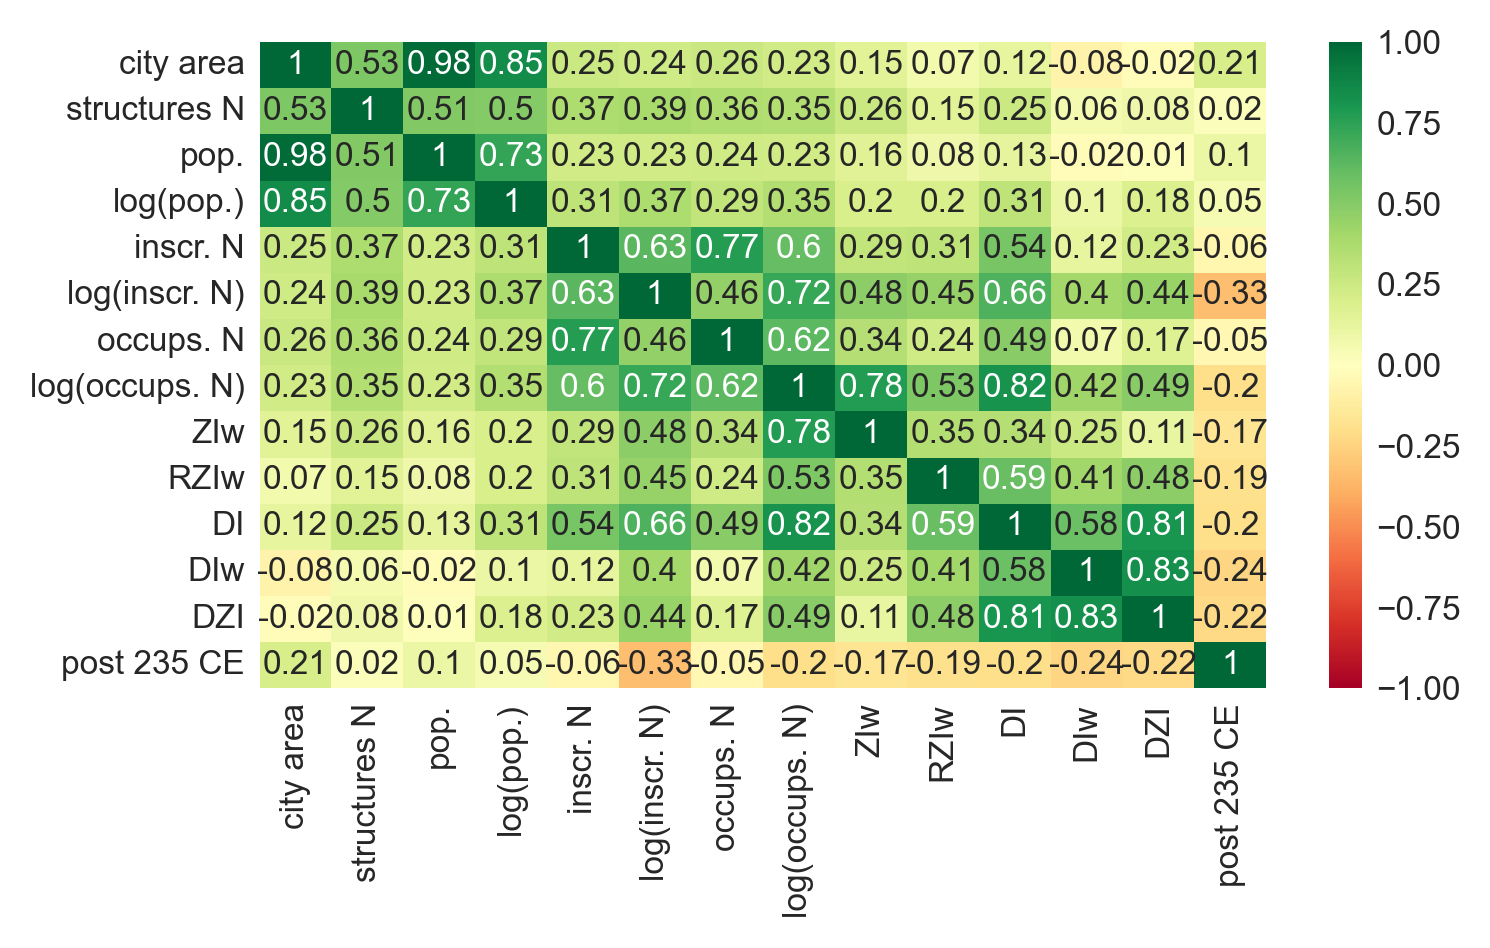

In [371]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "ZIw", "RZIw", "DI", "DIw", "DZI", "post 235 CE"]
fig,ax=plt.subplots(figsize=(5.2,3.2), tight_layout=True)
sns.heatmap(corr_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax,  cmap="RdYlGn", vmin=-1, vmax=1, annot=True)

In [372]:
save_figure(fig, "DI_ZI_corr_matrix")

A file with the same name ("DI_ZI_corr_matrix.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/DI_ZI_corr_matrix.eps"
A file with the same name ("DI_ZI_corr_matrix.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/DI_ZI_corr_matrix.png"


In [373]:
def get_pvalue_matrix(df):
    df = df.dropna()._get_numeric_data()
    listlist_pvalues = []
    for r in df.columns:
        row_pvalues = []
        for c in df.columns:
            try:
                row_pvalues.append(round(pearsonr(df[r], df[c])[1], 2))
            except:
                row_pvalues.append(None)
        listlist_pvalues.append(row_pvalues)
    return pd.DataFrame(listlist_pvalues, columns=df.columns, index=df.columns)

In [374]:
roman_cities_wo_quant

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,ZIw,RZIw,DI,DIw,DZI,ratio_post235
159,NaN,4,1000.0,6.907755,1.0,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
165,48.0,2,7376.0,8.905987,45.0,3.806662,5.0,1.609438,0.643775,8.712687,3.571429,2.219053,5.547633,0.177778
171,343.0,19,102074.0,11.533453,474.0,6.161207,9.0,2.197225,1.464816,10.916841,1.975610,0.899139,1.348708,0.082278
174,NaN,1,1000.0,6.907755,2.0,0.693147,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
177,156.0,14,35625.0,10.480803,13.0,2.564949,2.0,0.693147,0.693147,3.267271,1.000000,1.442695,1.442695,0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,131.0,21,28210.0,10.247432,120.0,4.787492,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.108333
1311,67.0,7,11517.0,9.351579,6.0,1.791759,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667
1315,36.0,5,5022.0,8.521584,29.0,3.367296,2.0,0.693147,0.693147,2.907001,1.000000,1.442695,1.442695,0.206897
1317,33.0,7,4471.0,8.405367,28.0,3.332205,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [375]:
pvalue_matrix = get_pvalue_matrix(roman_cities_wo_quant)
pvalue_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,ZIw,RZIw,DI,DIw,DZI,ratio_post235
Area,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.01,0.24,0.05,0.17,0.75,0.00
num_of_structures,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.09,0.00,0.78,0.76,0.05
pop_est,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.02,0.47,0.19,0.15,0.50,0.00
pop_est_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.02,0.03,0.00,0.54,0.28,0.00
inscr_N,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.53
inscr_N_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
occups_N,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.57,0.02,0.60
occups_N_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
ZIw,0.01,0.00,0.02,0.02,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.55,0.05
RZIw,0.24,0.09,0.47,0.03,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


<AxesSubplot:>

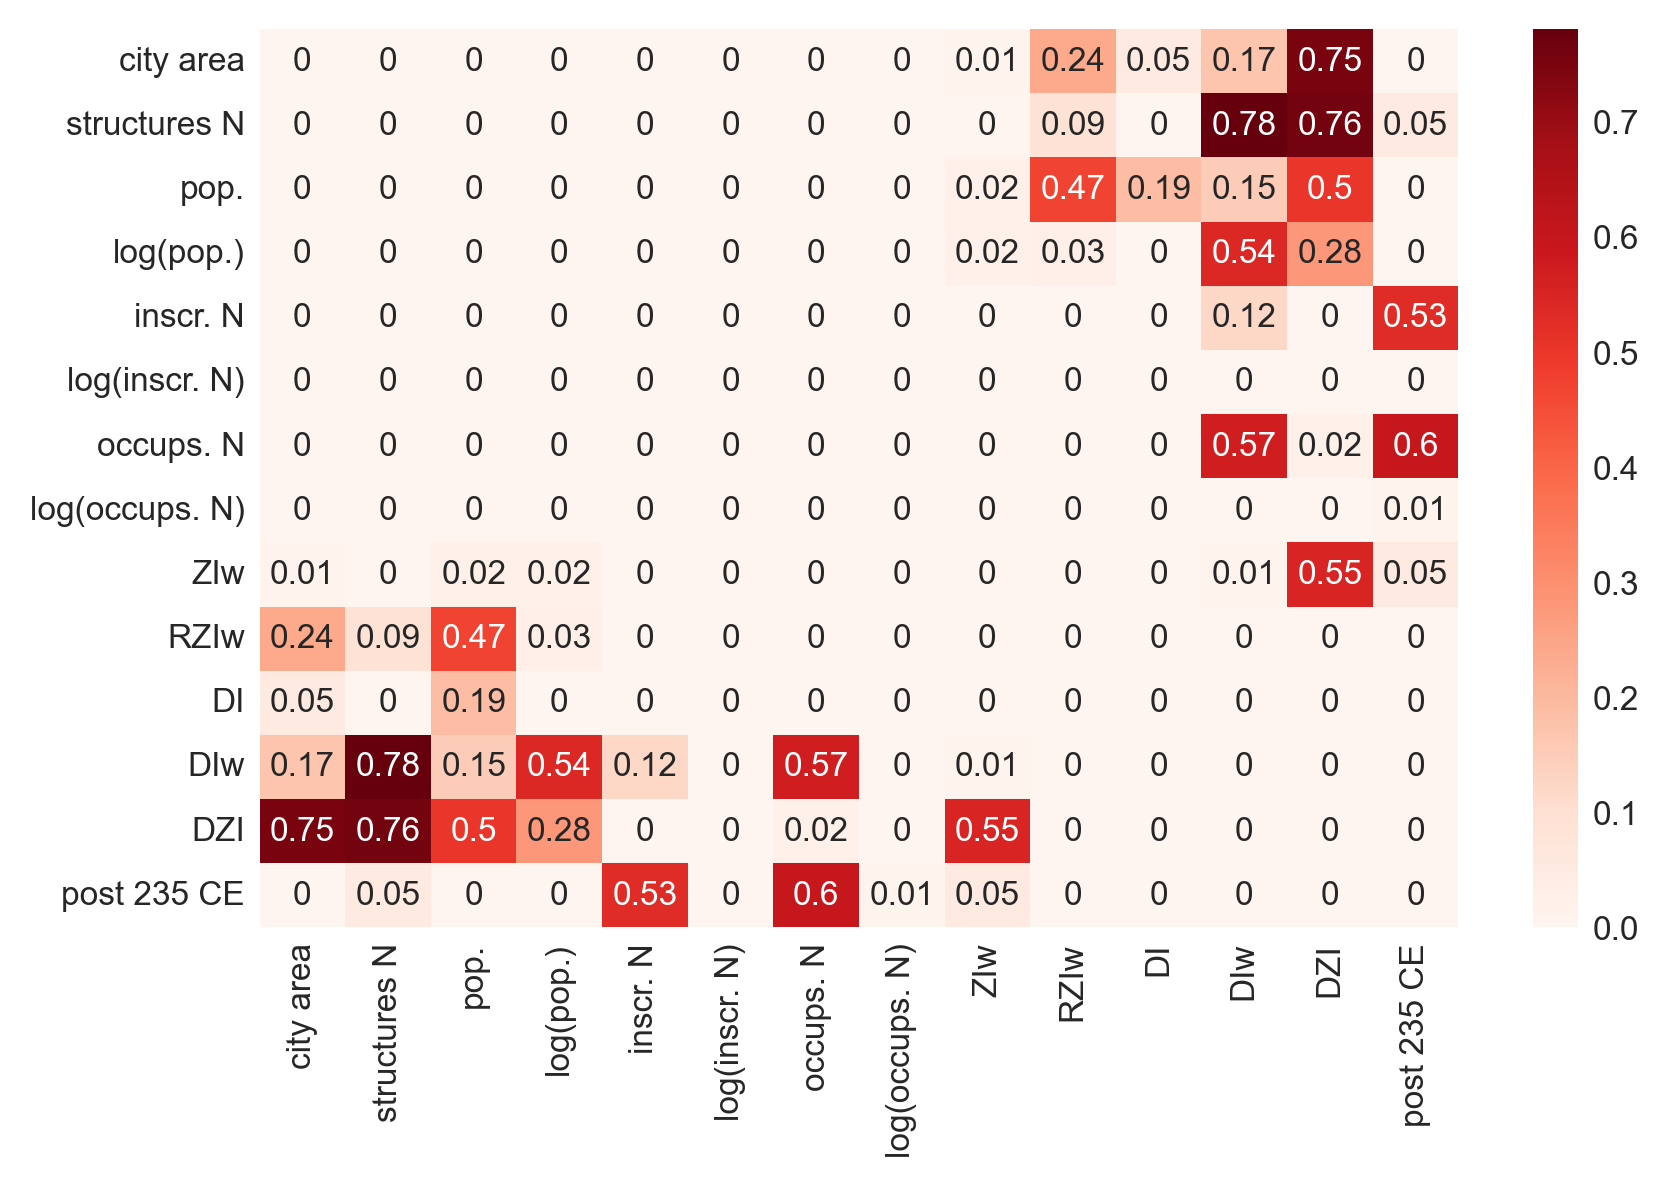

In [376]:
fig,ax=plt.subplots(tight_layout=True)
sns.heatmap(pvalue_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="Reds", annot=True)